# Access and Customize ICESat-2 Data Tutorial

### This tutorial will walk you though how to access ICESat-2 data at the NASA National Snow and Ice Data Center Distributed Active Archive Center (NSIDC DAAC) using spatial and temporal filters, as well as how to request customization services including subsetting and reformatting using an Application Programming Interface, or API. 

### Here is what you will learn in this tutorial:
       1) Setting up NASA Earthdata Login authentication for direct data access.
       2) Obtaining data set metadata.
       3) Inputting data set search criteria using spatial and temporal filters. 
       4) Exploring different methods of specifying spatial criteria including lat/lon bounds, polygon coordinate pairs, and polygon input from a Shapefile or KML.  
       5) Searching for matching files and receiving information about file volume.
       6) Obtaining information about subsetting and reformatting capabilities for a specfic data set.
       7) Configuring data request by "chunking" request by file number. 
       8) Submitting a request and monitoring the status of the request.
       
### Data Sets Used:
        's3://pangeo-data-upload-oregon/icesat2/pine_island_glims/glims_polygons.kml'
      
### Remaining issues/ to do:
       (if requests take too long then may the tutorial should just jump ahead and point to output
        previously requested)
        


## Import packages


In [2]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

## Pull data from s3 bucket

### We will first pull a Pine Island Glacier outline from our Amazon s3 bucket, which we will use below for filtering and subsetting the data.

Steps to pull pine island glacier folder from s3:

    1) Open terminal window in Pangeo: File -> New -> Terminal
    2) Copy the following line to terminal and hit enter:

`aws s3 sync s3://pangeo-data-upload-oregon/icesat2/pine_island_glims/ pine_island_glims/`

#### The Pine Island Glacier outline was originally downloaded from the the NSIDC [Global Land Ice Measurements from Space (GLIMS) database](http://www.glims.org/maps/glims). Direct download access: http://www.glims.org/maps/download.html?download_type=id&clause=G263560E76894S

## Create a token

### We will generate a token needed in order to access data using your Earthdata Login credentials, and we will apply that token to the following queries. If you do not already have an Earthdata Login account, go to http://urs.earthdata.nasa.gov to register. Your password will be prompted for privacy.

In [5]:
# Earthdata Login credentials

# Enter your Earthdata Login user name
uid = 'amy.steiker'
# Enter your email address associated with your Earthdata Login account
email = 'amy.steiker@nsidc.org'
pswd = getpass.getpass('Earthdata Login password: ')

Earthdata Login password:  ·········


In [6]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)

A1516D39-933A-2386-B022-81A9410BF1A9


## Select a data set of interest and determine the number and size of granules available within a time range and location.

### Let's begin discovering ICESat-2 data by first inputting the data set of interest.

### See the [ICESat-2 Data Sets](https://nsidc.org/data/icesat-2/data-sets "ICESat-2 Data Sets") page for a list of all ICESat-2 data set titles and IDs. Below we will input data set ID ATL06, which is the ID for the "ATLAS/ICESat-2 L3A Land Ice Height" data set.

In [7]:
# Input data set ID (e.g. ATL06) of interest here, also known as "short name".

short_name = 'ATL06'

### From the ICESat-2 Data Sets page, you can find a link to each data set home page:

ATL06: https://nsidc.org/data/atl06

### From that home page, several resources are available, including an online user guide (within the User Guide tab of the landing page):
https://nsidc.org/data/atl06?qt-data_set_tabs=3#qt-data_set_tabs

### As well as a data dictionary with every data set variable described in detail:
https://nsidc.org/sites/nsidc.org/files/technical-references/ATL06-data-dictionary-v001.pdf

### Now we will determine the most recent version number of our data set. We will also find out how many data granules (files) exist over an area and time of interest. [The Common Metadata Repository](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation") is queried to explore this information. 

In [8]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
pprint.pprint(results)

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

In [9]:
# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
#pprint.pprint(results['feed']['entry'])
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

The most recent version of  ATL06  is  001


### Now that we have the most recent version of this data set, let's determine the number of granules available over our area and time of interest.

In [10]:
# Input temporal range 

# Input start date in yyyy-MM-dd format
start_date = '2019-02-20'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-02-23'
# Input end time in HH:mm:ss format
end_time = '23:59:59'

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'

### There are three different options for inputting an area of interest to applied to our granule (file) search:
#### 1) Bounding Box 
#### 2) Polygon coordinate pairs 
#### 3) Spatial file input, including Esri Shapefile or KML/KMZ. 

### If interested in the bounding box option, enter the lat/lon bounds

In [11]:
# Bounding Box spatial parameter in 'W,S,E,N' format

# Input bounding box
# Input lower left longitude in decimal degrees
LL_lon = ''
# Input lower left latitude in decimal degrees
LL_lat = ''
# Input upper right longitude in decimal degrees
UR_lon = ''
# Input upper right latitude in decimal degrees
UR_lat = ''
    
bounding_box = LL_lon + ',' + LL_lat + ',' + UR_lon + ',' + UR_lat
# aoi value used for subsetting logic below
aoi = '1'
print(bounding_box)

,,,


### If interested in the polygon coordinate pair option, enter the coordinate pairs. We can do this with separate x y lists that we can join and convert to the CMR parameter format.

In [13]:
# Polygon coordinate pair spatial parameter

#create list of x (longitude) values in decimal degrees
x = []
#create list of y (latitude) values in decimal degrees
y = []
xylist = list(zip(x, y))
# Polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon. 
# Input polygon coordinates as comma separated values in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on.
polygon = ','.join(map(str, list(sum(xylist, ()))))
print(polygon)
# aoi value used for subsetting logic below
aoi = '2'

### If interested in the Esri Shapefile or KML/KMZ input option, the following cell will:
       1) Convert a file to geojson format,
       2) Create a dictionary,
       3) Simplify and reorder the polygon using the shapely package, and 
       4) Convert back to dictionary to be applied to the CMR polygon parameter.  

In [14]:
# Spatial file input, including Esri Shapefile or KML/KMZ
    
# POST shapefile or KML polygon to OGR for geojson conversion
url = 'http://ogre.adc4gis.com/convert'
shapefile = str(os.getcwd()) + '/pine_island_glims/glims_polygons.kml'
files = {'upload': open(shapefile, 'rb')}
r = requests.post(url, files=files)
results = json.loads(r.content)
    
# Results is a dictionary representing a feature collection. List coordinates from the Polygon feature:
polygon_list = list(results['features'][0]['geometry']['coordinates'][0])
    
    
# Remove z value from polygon list
for i in range(len(polygon_list)):
    del polygon_list[i][2]
    
# Create shapely Polygon object for simplification and counter-clockwise ordering for CMR filtering
poly = Polygon(tuple(polygon_list))
    
# Simplify polygon
s = poly.simplify(0.05, preserve_topology=False)
    
# Orient counter-clockwise
cc = orient(s, sign=1.0)
    
# From polygon object back to dictionary
poly_dict = mapping(cc)

# Format dictionary to polygon coordinate pairs for CMR polygon filtering
# Polygon points need to be provided in counter-clockwise order as comma separated values in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on. 
# The last point should match the first point to close the polygon. 
c = list(poly_dict['coordinates'][0])
polygon = ','.join(map(str, list(sum(c, ()))))
# aoi value used for subsetting logic below
aoi = '3'
print(polygon)

-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.449791,-76.666392,-101.310795,-76.691373,-101.357407,-76.744819,-101.217404,-76.769752,-101.295133,-76.85887,-101.058051,-76.962123,-100.447336,-7

### Let's take a look at the KML of Pine Island Glacier 

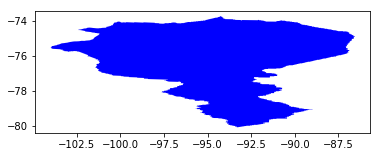

In [15]:
#import geojson python dictionary as Geodataframe
gdf = gpd.GeoDataFrame.from_features(results['features'])

#render figure in notebook
%matplotlib inline

polygon_plot = gdf.plot(color='blue')

### We will now populate dictionaries to be applied to our search query below based on spatial and temporal inputs. For additional search parameters, see the [The Common Metadata Repository API documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation").

In [16]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

print('CMR search parameters: ', params)

CMR search parameters:  {'short_name': 'ATL06', 'version': '001', 'temporal': '2019-02-20T00:00:00Z,2019-02-23T23:59:59Z', 'page_size': 100, 'page_num': 1, 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.3

### Input the parameter dictionary to the CMR granule search to query all files (granules) that meet the criteria based on the granule metadata.

In [17]:
# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')


There are 16 granules of ATL06 version 001 over my area and time of interest.


### We can view this in the [NASA Earthdata Search web interface](https://search.earthdata.nasa.gov/search/granules?polygon=-86.625%2C-74.900390625%2C-87.029296875%2C-74.6015625%2C-90.298828125%2C-74.021484375%2C-93.427734375%2C-73.93359375%2C-94.359375%2C-73.74023437500001%2C-96.767578125%2C-74.126953125%2C-100.107421875%2C-74.021484375%2C-100.828125%2C-74.37304687500001%2C-102.427734375%2C-74.49609375%2C-101.25%2C-74.70703125%2C-101.548828125%2C-75.02343750000001%2C-104.009765625%2C-75.515625%2C-102.357421875%2C-75.744140625%2C-101.28515625%2C-76.201171875%2C-101.197265625%2C-76.271484375%2C-101.443359375%2C-76.658203125%2C-101.03906250000001%2C-76.93945312500001%2C-96.521484375%2C-77.484375%2C-96.43359375%2C-77.677734375%2C-97.611328125%2C-78.029296875%2C-95.02734375%2C-78.591796875%2C-94.9921875%2C-78.732421875%2C-95.677734375%2C-78.99609375%2C-95.27343750000001%2C-79.119140625%2C-95.431640625%2C-79.2421875%2C-93.990234375%2C-79.611328125%2C-93.884765625%2C-79.875%2C-93.234375%2C-80.0859375%2C-91.705078125%2C-79.875%2C-91.810546875%2C-79.857421875%2C-91.494140625%2C-79.8046875%2C-91.458984375%2C-79.646484375%2C-90.43945312500001%2C-79.59375%2C-90.544921875%2C-79.55859375%2C-90.03515625%2C-79.2421875%2C-88.98046875%2C-79.083984375%2C-92.03906250000001%2C-78.416015625%2C-92.109375%2C-78.310546875%2C-90.73828125%2C-77.90625000000001%2C-92.390625%2C-77.501953125%2C-92.197265625%2C-77.37890625%2C-92.337890625%2C-77.203125%2C-91.01953125%2C-77.150390625%2C-91.880859375%2C-76.869140625%2C-87.064453125%2C-75.884765625%2C-86.87109375%2C-75.708984375%2C-87.08203125%2C-75.4453125%2C-86.607421875%2C-75.005859375%2C-86.625%2C-74.900390625&p=C1511847675-NSIDC_ECS&m=-75.86169083955123!-125.33434054992857!1!2!0!0%2C2&tl=1550931057!3!!&qt=2019-02-20T00%3A00%3A00.000Z%2C2019-02-23T23%3A59%3A59.000Z&q=atl06&ok=atl06&sf=5633090487), which relies on the same metadata, although their simplified polygon may differ slightly. With the same search criteria applied, we can view the same 16 granules of ATL06 over the glacier.

### We will now query the average size of those granules as well as the total volume. 

In [18]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')


The average size of each granule is 62.66 MB and the total size of all 16 granules is 1002.57 MB


#### Although subsetting, reformatting, or reprojecting can alter the size of the granules, this "native" granule size can still be used to guide us towards the best download method to pursue, which we will come back to later on in this tutorial.

## Select the subsetting and reformatting services enabled for your data set of interest.

### The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Reformatting and subsetting are available on all Level-2 and -3 ICESat-2 data sets. Let's discover the specific service options supported for this data set and select which of these services we want to request. 

### We will start by querying the service capability endpoint and gather service information that we will select in the next step.

In [19]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]


### We will now select subsetting and reformatting options.

In [20]:
#print service information depending on service availability and select service options
    
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    bbox = ''
    timevar = ''
    reformat = ''
    projection = ''
    projection_parameters = ''
    coverage = ''
    polygon = ''
else:
    agent = ''
    subdict = subagent[0]
    #icesat-2 spatial subsetting logic
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi == '1':
        print('Subsetting by bounding box, based on the area of interest inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        bounding_shape = ''
        polygon = ''
        if ss == 'y': 
            bbox = bounding_box
        else: 
            bbox = ''
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi == '2':
        print('Subsetting by polygon, based on area of interest inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        bounding_box = ''
        bounding_shape = ''
        if ss == 'y':
            #get polygon bounds to be used as bounding box input
            #Create shapely Polygon object from x y list
            p = Polygon(tuple(xylist))
            # Extract the point values that define the perimeter of the polygon
            bounds = p.bounds
            bbox = ','.join(map(str, list(bounds)))
        else: 
            bbox = ''
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi == '3':
        print('Subsetting by polygon, based on the original spatial file inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        bbox = ''
        bounding_box = ''
        bounding_shape = ''
        if ss == 'y': upload = 'T'
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] != 'ICESAT2':
        polygon = ''
        print('Subsetting by bounding box, based on the area of interest inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        if ss == 'y': bbox = bounding_box
        else: 
            bbox = ''
            polygon = ''
    if subdict['temporalSubsetting'] == 'true':
        print('Subsetting by time, based on the temporal range inputted above, is available.')
        ts = input('Would you like to request this service? (y/n)')
        if ts == 'y': timevar = temporal 
        else: timevar = ''
    else: timevar = ''
    if len(format_vals) > 0 :
        print('These reformatting options are available:', format_vals)
        reformat = input('If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.')
        # select reprojection options based on reformatting selection
        if reformat in format_proj and len(proj_vals) > 0 : 
            print('These reprojection options are available with your requested format:', proj_vals)
            projection = input('If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes, e.g. GEOGRAPHIC), otherwise leave blank.')
            # Enter required parameters for UTM North and South
            if projection == 'UTM NORTHERN HEMISPHERE' or projection == 'UTM SOUTHERN HEMISPHERE': 
                NZone = input('Please enter a UTM zone (1 to 60 for Northern Hemisphere; -60 to -1 for Southern Hemisphere):')
                projection_parameters = str('NZone:' + NZone)
            else: projection_parameters = ''
        else: 
            print('No reprojection options are supported with your requested format')
            projection = ''
            projection_parameters = ''
    else: 
        reformat = ''
        projection = ''
        projection_parameters = ''


Subsetting by polygon, based on the original spatial file inputted above, is available.


Would you like to request this service? (y/n) n


Subsetting by time, based on the temporal range inputted above, is available.


Would you like to request this service? (y/n) n


These reformatting options are available: ['TABULAR_ASCII', 'NetCDF4-CF', 'Shapefile', 'NetCDF-3']


If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank. 


No reprojection options are supported with your requested format


### Because variable subsetting can include a long list of variables to choose from, we will decide on variable subsetting separately from the service options above.

In [24]:
# Select variable subsetting

if len(variable_vals) > 0:
        v = input('Variable subsetting is available. Would you like to subset a selection of variables? (y/n)')
        if v == 'y':
            print('The', short_name, 'variables to select from include:')
            pprint.pprint(variable_vals)
            coverage = input('If you would like to subset by variable, copy and paste the variables you would like separated by comma. Make sure to omit quotes but include all forward slashes: ')
        else: coverage = ''

#no services selected
if reformat == '' and projection == '' and projection_parameters == '' and coverage == '' and timevar == '' and bbox == '' and bounding_shape == '' and aoi != '3':
    agent = 'NO'
elif aoi == '3' and ss != 'y':
    agent = 'NO'
else: agent = ''

Variable subsetting is available. Would you like to subset a selection of variables? (y/n) n


## Request data from the NSIDC data access API.

 _What is an API? API stands for Application Programming Interface. You can think of it as a middle man between an application or end-use (in this case, us) and a data provider (in this case, the Common Metadata Repository and NSIDC). These APIs are essentially structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’._

### We will now set up our data download request. Recall that we queried the total number and volume of granules prior to applying customization services, so you can use these values to adjust the number of granules per request up to a limit of 100 granules. 

### For now, let's select 10 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. We will also set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

In [25]:
# Determine how many individual orders we will request based on the number of granules requested

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10
page_num = math.ceil(len(granules)/page_size)

#Set request mode. Request mode is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory.
request_mode = 'async'


#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 2 total order(s) processed for our ATL06 request.


In [26]:
#Print API base URL + request parameters
API_request = base_url + '?' + 'short_name=' + short_name + '&' + 'version=' + latest_version + '&' + 'temporal=' + temporal + '&' + 'time=' + timevar + '&' + 'bounding_box=' + bounding_box + '&' + 'polygon=' + polygon + '&' + 'bbox=' + bbox + '&' + 'bounding_shape=' + bounding_shape + '&' +  'format=' + reformat + '&' + 'projection=' + projection + '&' + 'projection_parameters=' + projection_parameters + '&' + 'Coverage=' + coverage + '&' + 'request_mode=' + request_mode + '&' + 'page_size=' + str(page_size) + '&' + 'page_num=1&' + 'agent=' + agent + '&' + 'token=' + token + '&' + 'email=' + email
print(API_request)

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-20T00:00:00Z,2019-02-23T23:59:59Z&time=&bounding_box=&polygon=-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,

### Now, let's download the data directly to this notebook directory in a new Outputs folder. The progress of each order will be reported.

In [ ]:
#post polygon


In [27]:
# Create Outputs folder if folder does not already exist, request data service for each page number, and unzip outputs

path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

for i in range(page_num):
    page_val = i + 1
    print(page_val)
    request_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'time': timevar, 'bounding_box': bounding_box, 'polygon': polygon, 'bbox': bbox, 'bounding_shape': bounding_shape, 'format': reformat, 'projection': projection, 'projection_parameters': projection_parameters, 'Coverage': coverage, 'request_mode': request_mode, 'page_size': page_size, 'page_num': page_val, 'agent': agent, 'token': token, 'email': email, }
    print(request_params)
    #Initial order response 
    data_session = requests.session()
    data_s = data_session.get(base_url, params=request_params)
    data_response = session.get(data_s.url,auth=(uid,pswd))
    esir_root = ET.fromstring(data_response.content)
    #Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID' + ' ' + orderID)

    #Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ' + statusURL)
    #Find order status
    request_session = requests.session()
    request_s = request_session.get(statusURL)
    request_response = session.get(request_s.url,auth=(uid,pswd))
    print('HTTP request response: '), request_response
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request', page_val, 'is submitting...')
    print('Initial request status is ' + status)

    #Continue loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(5)
        loop_session = requests.session()
        loop_s = loop_session.get(statusURL)
        loop_response = session.get(loop_s.url,auth=(uid,pswd))
        loop_root = ET.fromstring(loop_response.content)
        #find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is' + ' ' + status)
        if status == 'pending' or status == 'processing':
            continue

    print('Request status is complete. Beginning download of zipped output.')
    downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
    zip_session = requests.session()
    zip_s = zip_session.get(downloadURL)
    zip_response = session.get(zip_s.url,auth=(uid,pswd))
    with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
        z.extractall(path)
    print('Data request', page_val, 'is complete.')


1
{'short_name': 'ATL06', 'version': '001', 'temporal': '2019-02-20T00:00:00Z,2019-02-23T23:59:59Z', 'time': '', 'bounding_box': '', 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.4

### Finally, we will clean up the Output folder by removing individual order folders:

In [28]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [29]:
#List files
os.listdir(path)

['ATL06_20190223152825_08730211_001_01.h5',
 'ATL06_20190221161942_08430211_001_01.iso.xml',
 'ATL06_20190222031203_08500210_001_01.iso.xml',
 'ATL06_20190220165104_08280212_001_01.h5',
 'ATL06_20190222031944_08500211_001_01.h5',
 'ATL06_20190222155947_08580212_001_01.iso.xml',
 'ATL06_20190223024624_08650210_001_01.iso.xml',
 'ATL06_20190221033742_08350210_001_01.iso.xml',
 'ATL06_20190223153408_08730212_001_01.iso.xml',
 'ATL06_20190220022903_08190210_001_01.iso.xml',
 'ATL06_20190221162525_08430212_001_01.h5',
 'ATL06_20190223025405_08650211_001_01.h5',
 'ATL06_20190220164521_08280211_001_01.iso.xml',
 'ATL06_20190221034523_08350211_001_01.h5',
 'ATL06_20190220023644_08190211_001_01.iso.xml',
 'ATL06_20190222155404_08580211_001_01.h5',
 'ATL06_20190220023644_08190211_001_01.h5',
 'ATL06_20190220164521_08280211_001_01.h5',
 'ATL06_20190222031944_08500211_001_01.iso.xml',
 'ATL06_20190220165104_08280212_001_01.iso.xml',
 'ATL06_20190220022903_08190210_001_01.h5',
 'ATL06_2019022315282

In [30]:
#remove Outputs folder for testing

shutil.rmtree(path)

glacier_path = str(os.getcwd() + '/pine_island_glims')
#print(glacier_path)
shutil.rmtree(glacier_path)


### To review, we have explored data availability and volume over a region and time of interest, discovered and selected data customization options, and downloaded data directly to our local machine. You are welcome to request different data sets, areas of interest, and/or customization services by re-running the notebook or starting again at the 'Select a data set of interest' step above. 